In [ ]:
#| hide
%load_ext autoreload 
%autoreload 2 

# cheng2023TransRVNet

> Module that implements the models from [TransRVNet: LiDAR Semantic Segmentation With Transformer](https://ieeexplore.ieee.org/document/10056404).

**(UNDER CONSTRUCTION...)**

In [ ]:
#| default_exp cheng2023TransRVNet

In [ ]:
#| hide
from nbdev.showdoc import show_doc

In [ ]:
#| hide
# !pip install timm

In [ ]:
#| export
from __future__ import print_function, division

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import functional as transforms_F
import torch.utils.checkpoint as checkpoint
import numpy as np
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import random
from colorcloud.behley2019iccv import plot_projections, SemanticKITTIDataset, ProjectionVizTransform,  ProjectionTransform, SphericalProjection
from torchvision.transforms import v2
from lightning import LightningModule
from torchmetrics.classification import Accuracy
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import wandb
from torch.nn.modules.module import register_module_forward_hook

from torch.autograd import Variable
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Complete architecture

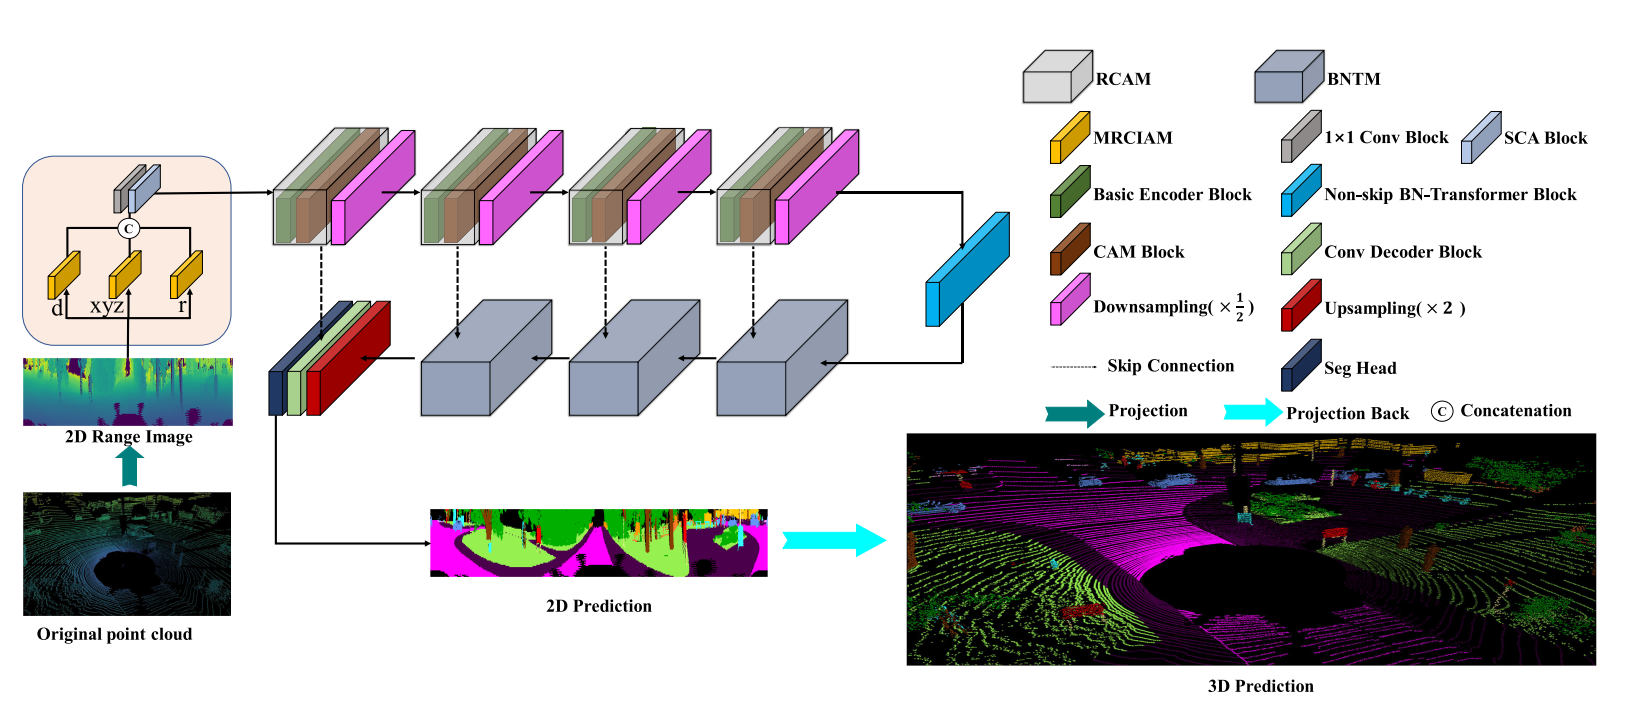

## Utils

In [ ]:
#| export
class ConvBNPReLU(nn.Module):
    "Sequential composition of 2D convolution, batch normalization and PReLU."
    def __init__(self, 
                 in_channels:int,      # input channels size
                 out_channels:int,     # output channels size
                 kernel_size:int,
                 stride=1,
                 padding=0,
                 dilation=1
                )->torch.Tensor:  # ()
        super(ConvBNPReLU, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation=dilation)
        self.batchNormalization = nn.BatchNorm2d(out_channels)
        self.activation = nn.PReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.batchNormalization(out)
        out = self.activation(out)
        return out

## MRCIAM

In [ ]:
#|export 
class SACBlock(nn.Module):
    """Divides the input feature map into groups, integrating channel and spatial 
    attention for each group using the Shuffle Unit, aggregating all sub-features, 
    and finally using a channel shuffle operator to enable information exchange between different sub-features.
    """
    def __init__(self, 
                 channel:int,  # input channels size
                 groups=32
                )->torch.Tensor:
        super(SACBlock, self).__init__()
        self.groups = groups
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.cweight = nn.Parameter(torch.zeros(1, channel // (2 * groups), 1, 1))
        self.cbias = nn.Parameter(torch.ones(1, channel // (2 * groups), 1, 1))
        self.sweight = nn.Parameter(torch.zeros(1, channel // (2 * groups), 1, 1))
        self.sbias = nn.Parameter(torch.ones(1, channel // (2 * groups), 1, 1))

        self.sigmoid = nn.Sigmoid()
        self.gn = nn.GroupNorm(channel // (2 * groups), channel // (2 * groups))

    def channel_shuffle(self, x, groups):
        b, c, h, w = x.shape

        x = x.reshape(b, groups, -1, h, w)
        x = x.permute(0, 2, 1, 3, 4)

        # flatten
        x = x.reshape(b, -1, h, w)

        return x

    def forward(self, x): 
        b, c, h, w = x.shape

        # group into subfeatures
        x = x.reshape(b * self.groups, -1, h, w)

        # channel split
        x_0, x_1 = x.chunk(2, dim=1)

        # channel attention
        xn = self.avg_pool(x_0)
        xn = self.cweight * xn + self.cbias
        xn = x_0 * self.sigmoid(xn)

        # spatial attention
        xs = self.gn(x_1)
        xs = self.sweight * xs + self.sbias
        xs = x_1 * self.sigmoid(xs)

        # concatenate along channel axis
        out = torch.cat([xn, xs], dim=1)
        out = out.reshape(b, -1, h, w)

        # channel shuffle
        out = self.channel_shuffle(out, 2)
        return out

The SACBlock implementation is based on the code from TransRVNet's SalsaNext module.
Source: [TransRVNet's SalsaNext.py](https://github.com/huixiancheng/TransRVNet/blob/main/modules/SalsaNext.py)

More information about SCA block [SA-NET: SHUFFLE ATTENTION FOR DEEP CONVOLUTIONAL NEURAL NETWORKS](https://arxiv.org/pdf/2102.00240)

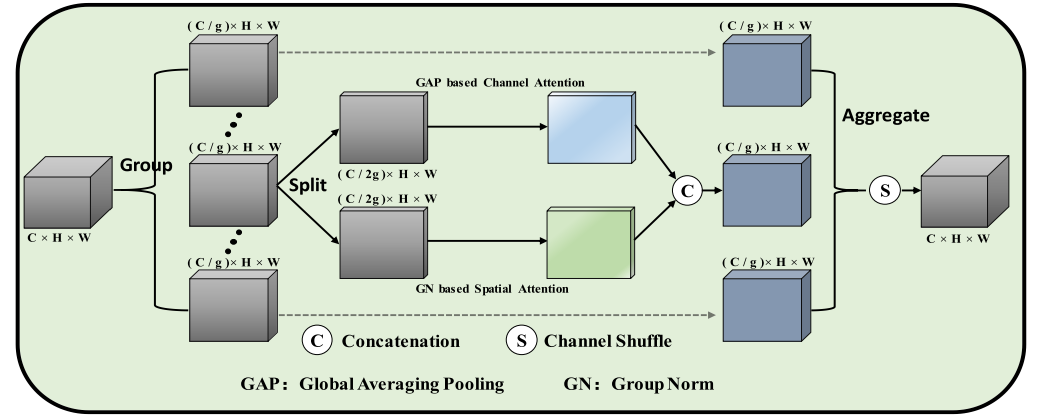

In [ ]:
#| export
class MRCIAMSingleChannel(nn.Module):
    """
    Implementaton of MRCIAMSingleChannel.
    """
    def __init__(self, 
                 parameters:dict # dictonary with the input channels and output channels of each ConvBNPReLU bellow is a example
                )->torch.Tensor: #
        super(MRCIAMSingleChannel, self).__init__()
        # Bloco 1
        self.block1_3x3 = ConvBNPReLU(parameters["b1_in"], parameters["b1_out1"], kernel_size=3, padding=1)
        self.block1_5x5 = ConvBNPReLU(parameters["b1_in"], parameters["b1_out2"], kernel_size=5, padding=2)
        self.block1_7x7 = ConvBNPReLU(parameters["b1_in"], parameters["b1_out3"], kernel_size=7, padding=3)
        __concat_size = parameters["b1_out1"] + parameters["b1_out2"] + parameters["b1_out3"]
        self.block1_3x3_2 = ConvBNPReLU(__concat_size, parameters["b2_in"], kernel_size=3, padding=1)
        self.block1_1x1 = ConvBNPReLU(parameters["b1_in"], parameters["b2_in"], kernel_size=1)

        # Bloco 2
        self.block2_3x3 = ConvBNPReLU(parameters["b2_in"], parameters["b2_out"], kernel_size=3, padding=1)
        self.block2_3x3_dilated = ConvBNPReLU(parameters["b2_out"], parameters["b3_in"], kernel_size=3, padding=2, dilation=2)
        self.block2_1x1 = ConvBNPReLU(parameters["b2_in"], parameters["b3_in"], kernel_size=1)

        # Bloco 3
        self.block3_3x3 = ConvBNPReLU(parameters["b3_in"], parameters["b3_out1"], kernel_size=3, padding=1)
        self.block3_5x5 = ConvBNPReLU(parameters["b3_in"], parameters["b3_out2"], kernel_size=5, padding=2)
        self.block3_7x7 = ConvBNPReLU(parameters["b3_in"], parameters["b3_out3"], kernel_size=7, padding=3)
        __concat_size2 = parameters["b3_out1"] + parameters["b3_out2"] + parameters["b3_out3"]
        self.block3_3x3_2 = ConvBNPReLU(__concat_size2, parameters["output"], kernel_size=3, padding=1)
        self.block3_1x1 = ConvBNPReLU(parameters["b3_in"], parameters["output"], kernel_size=1)

        # SCA Block
        self.sac_block = SACBlock(parameters["output"])

    def forward(self, x):
        # Bloco 1
        conv1_3x3_out = self.block1_3x3(x)
        conv1_5x5_out = self.block1_5x5(x)
        conv1_7x7_out = self.block1_7x7(x)
        concat_out = torch.cat((conv1_3x3_out, conv1_5x5_out, conv1_7x7_out), 1)
        conv1_out = self.block1_3x3_2(concat_out)
        conv1x1_1_out = self.block1_1x1(x)
        block1_out = conv1_out + conv1x1_1_out

        # Bloco 2
        conv2_3x3_out = self.block2_3x3(block1_out)
        conv2_3x3_dilated_out = self.block2_3x3_dilated(conv2_3x3_out)
        conv1x1_out = self.block2_1x1(block1_out)
        block2_out = conv2_3x3_dilated_out + conv1x1_out

        # Bloco 3
        conv3_3x3_out = self.block3_3x3(block2_out)
        conv3_5x5_out = self.block3_5x5(block2_out)
        conv3_7x7_out = self.block3_7x7(block2_out)
        concat_out_2 = torch.cat((conv3_3x3_out, conv3_5x5_out, conv3_7x7_out), 1)
        conv3_out = self.block3_3x3_2(concat_out_2)
        conv1x1_6_out = self.block3_1x1(block2_out)
        block3_out = conv3_out + conv1x1_6_out

        # SAC Block
        out = self.sac_block(block3_out)

        return out

**Here is a template on how to use define the MRCIAM parameters:**

```
parameters = {
    "b1_in": 1,
    "b1_out1": 1,
    "b1_out2": 1,
    "b1_out3": 1,
    "b2_in": 32,
    "b2_out": 32,
    "b3_in": 64,
    "b3_out1": 64,
    "b3_out2": 64,
    "b3_out3": 64,
    "output": 128,
}
```

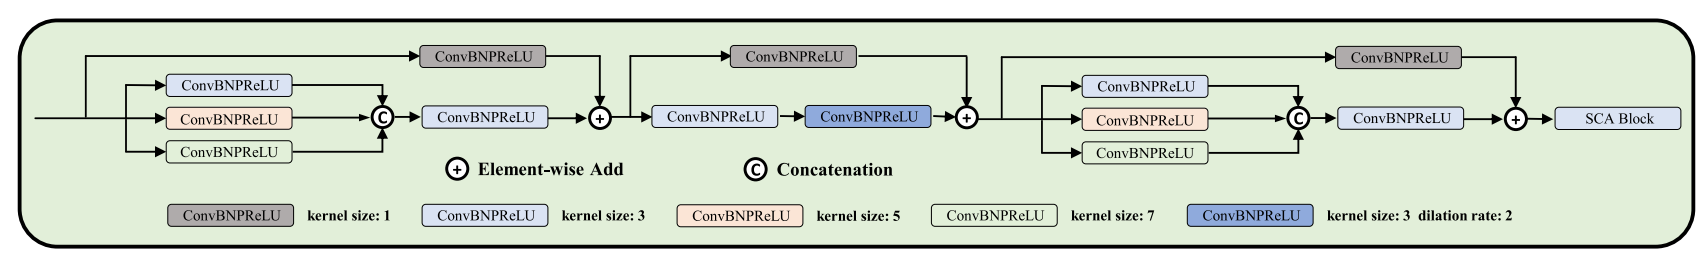

In [ ]:
#| hide
parameters = {
    "b1_in": 1,
    "b1_out1": 1,
    "b1_out2": 1,
    "b1_out3": 1,
    "b2_in": 32,
    "b2_out": 32,
    "b3_in": 64,
    "b3_out1": 64,
    "b3_out2": 64,
    "b3_out3": 64,
    "output": 128,
}

Here is an example on how to use it:

In [ ]:
# using the parameters dict of template
model = MRCIAMSingleChannel(parameters)

# Random Tensor representing input
input_tensor = torch.randn(4, 1, 32, 512)

output = model(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([4, 128, 32, 512])


In [ ]:
#|export 
class MRCIAM(nn.Module):
    """
    MRCIAM module is the agregation of 3 MRCIAMSingleChannel, each will compute
    3 input types, the xyz, reflectance and depth
    """
    def __init__(self,
                 p1,   # dict for mrciam_depth_reflectance
                 p2    # dict for mrciam_xyz
                )->torch.Tensor:
        super(MRCIAM, self).__init__()
        self.mrciam_depth_reflectance = MRCIAMSingleChannel(p1)
        self.mrciam_xyz = MRCIAMSingleChannel(p2)

        self.conv_1x1 = ConvBNPReLU(384, 384, kernel_size=1)

        # SCA Block
        self.sac_block = SACBlock(384)

    def forward(self, x1, x2, x3):
      mrciam_x1 = self.mrciam_depth_reflectance(x1)
      mrciam_x2 = self.mrciam_depth_reflectance(x2)
      mrciam_x3 =  self.mrciam_xyz(x3)

      concat_out = torch.cat((mrciam_x1, mrciam_x2, mrciam_x3), 1)

      conv_out = self.conv_1x1(concat_out)

      out = self.sac_block(conv_out)

      return out

Two sets of parameters, `p1` and `p2`, are provided. 

- **`p1`** represents the parameters for processing single-channel images, such as those representing depth and reflectance.
- **`p2`** represents the parameters for processing three-channel images, such as those representing XYZ coordinates.

Each contains the following parameters:

- `b1_in`: Input shape for the initial convolutional layers in Block 1 of the MRCIAM network.
- `b1_out1`, `b1_out2`, `b1_out3`: Output channel dimensions for the three parallel convolutional paths in Block 1.
- `b2_in`: Input channel dimension for the subsequent convolutional layers in Block 2.
- `b2_out`: Output channel dimension for the convolutional layer in Block 2.
- `b3_in`: Input channel dimension for the subsequent convolutional layers in Block 3.
- `b3_out1`, `b3_out2`, `b3_out3`: Output channel dimensions for the three parallel convolutional paths in Block 3.
- `output`: Final output channel dimension of the MRCIAM network.

In [ ]:
#| hide
p1 = {
    "b1_in": 1,
    "b1_out1": 1,
    "b1_out2": 1,
    "b1_out3": 1,
    "b2_in": 32,
    "b2_out": 32,
    "b3_in": 64,
    "b3_out1": 64,
    "b3_out2": 64,
    "b3_out3": 64,
    "output": 128,
}

p2 = {
    "b1_in": 3,
    "b1_out1": 1,
    "b1_out2": 1,
    "b1_out3": 1,
    "b2_in": 32,
    "b2_out": 32,
    "b3_in": 64,
    "b3_out1": 64,
    "b3_out2": 64,
    "b3_out3": 64,
    "output": 128,
}

Here is an example on how to use it:

In [ ]:
model = MRCIAM(p1, p2)

# Random Tensor representing depth and reflectance
input_tensor = torch.randn(1, 1, 64, 1024)
# Random Tensor representing x, y, z
input_tensor2 = torch.randn(1, 3, 64, 1024)

input_encoder = model(input_tensor, input_tensor, input_tensor2)
print("Output shape:", input_encoder.shape)

Output shape: torch.Size([1, 384, 64, 1024])


## Encoder

In [ ]:
#| export
class BasicEncoderBlock(nn.Module):
    """
    Basic block of encoder module
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int # output size returned by the BasicEncoderBlock
                )->torch.Tensor:  
        super(BasicEncoderBlock, self).__init__()
        self.conv1 = ConvBNPReLU(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = ConvBNPReLU(64, 64, kernel_size=3, padding=1)
        self.dilated_conv = ConvBNPReLU(64, 64, kernel_size=3, padding=2, dilation=2)

        self.residual_conv1 = ConvBNPReLU(256, out_channels, kernel_size=1)
        self.residual_conv2 = ConvBNPReLU(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # 3 ConvBNPReLU
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.dilated_conv(out2)

        # Concatanation
        concat_out = torch.cat((out1, out2, out3, out3), 1)

        # ConvBNPReLU of first concatenation
        out_residual1 = self.residual_conv1(concat_out)
        # ConvBNPReLU of input
        out_residual2 = self.residual_conv2(x)
        # Element-wise Add
        out = out_residual1 + out_residual2

        return out

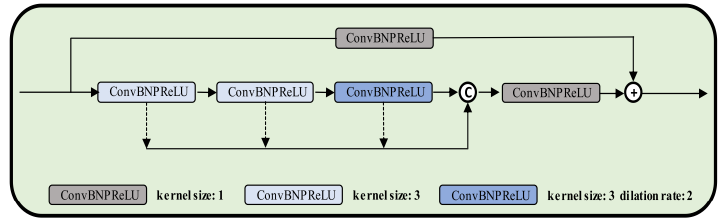

In [ ]:
#| export
class CAM(nn.Module):
    """
    Context aggregation module
    """
    def __init__(self, 
                 inplanes:int
                )->int: # 
        super(CAM, self).__init__()
        self.pool = nn.MaxPool2d(7, 1, 3)
        self.Conv2d = nn.Conv2d(inplanes, inplanes // 16, kernel_size=1, stride=1)
        self.BatchNorm2d = nn.BatchNorm2d(inplanes // 16)
        self.Conv2d_2 = nn.Conv2d(inplanes // 16, inplanes, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 7x7 pooling
        y = self.pool(x)
        # Conv2d and BatchNorm2d
        y = self.BatchNorm2d(self.Conv2d(y))
        # Conv2d_2 and Sigmoid
        y = self.sigmoid(self.Conv2d_2(y))
        # Element-wise Multiply
        return y * x

The CAM implementation is based on the code from TransRVNet's SalsaNext module.
Source: [TransRVNet's SalsaNext.py](https://github.com/huixiancheng/TransRVNet/blob/main/modules/SalsaNext.py)

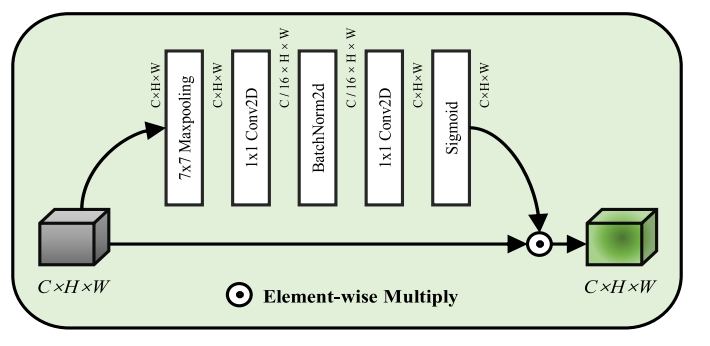

In [ ]:
#| export
class EncoderModule(nn.Module):
    """
    Encoder module, is the agregation of 1 Basic encoder block followed by 1 CAM
    """
    def __init__(self, 
                 in_channels:int,
                 out_channels:int
                )->int: # output size of basic encoder block
        super(EncoderModule, self).__init__()
        self.encoder_block = BasicEncoderBlock(in_channels, out_channels)
        # in_channels of CAM is the out_shape of BasicEncoderBlock, see BasicEncoderBlock
        self.cam = CAM(out_channels)
        self.avg_pool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        out = self.cam(self.encoder_block(x))
        x = self.avg_pool(out)

        return x, out

```{mermaid}
flowchart LR
    direction TB
    subgraph E["Encoder Module"]
        direction LR
        BasicEncoderBlock --> CAM
    end
    Input --> BasicEncoderBlock
    CAM --> Output
```

Here is an example on how to use it:

In [ ]:
input_encoder = torch.rand(4, 384, 32, 512)
encoder = EncoderModule(in_channels=384, out_channels=64)

out, outs_encoder = encoder(input_encoder)
print("Output shape:", out.shape)

Output shape: torch.Size([4, 64, 16, 256])


## Decoder
Transformer-based Balanced Non-square-Transformer Module (BNTM) is basicaly the implementation of the [swin tranformer](https://arxiv.org/abs/2103.14030) with some modifications

###  Balanced Non-square-Transformer Module

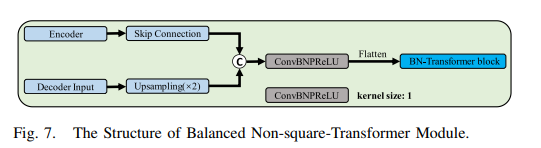

The Swin Transformer implementation is based on the code from TransRVNet's Swin Transformer module.
Source: [TransRVNet's Swin Transformer.py](https://github.com/huixiancheng/TransRVNet/blob/main/modules/swin_transformer.py)

In [ ]:
#| export
class GELU(nn.Module):
    """
    Activation function
    """
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh(np.sqrt(2/np.pi)*(x+0.044715*torch.pow(x,3))))

In [ ]:
#| export
class MLP(nn.Module):
    """
    A simple Multilayer perceptron.
    """
    def __init__(self, 
                 in_features:int, # in
                 hidden_features:int=None, 
                 out_features:int=None, 
                 act_layer:nn.Module=nn.GELU, 
                 drop:int=0.
                ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)

        x = self.drop(x)
        return x

### Window basics

In [ ]:
#| export
def window_partition(x:torch.Tensor, # (B, H, W, C)
                     window_size:int # window size
                    )->torch.Tensor: # (num_windows\*B, window_size, window_size, C)
    """
    do something
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0], W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0], window_size[1], C)
    return windows


In [ ]:
#| export
def window_reverse(windows:torch.Tensor, # (num_windows*B, window_size, window_size, C)
                   window_size:int,      # Window size
                   H:int,                # Height of image
                   W:int                 # Width of image
                  )->torch.Tensor:       # (B, H, W, C)
    """
    do something 
    """
    B = int(windows.shape[0] / (H * W / window_size[0] / window_size[1]))
    x = windows.view(B, H // window_size[0], W // window_size[1], window_size[0], window_size[1], -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [ ]:
#| export
class WindowAttention(nn.Module):
    """ Window based multi-head self attention (W-MSA) module with relative position bias.
        It supports both of shifted and non-shifted window.
    """
    def __init__(self, 
                 dim:int,             # Number of input channels.
                 window_size:tuple,   # The height and width of the window. **(tuple of int)**
                 num_heads:int,       # Number of attention heads.
                 qkv_bias:bool=True,  # If True, add a learnable bias to query, key, value.
                 qk_scale:float=None, # Override default qk scale of **head_dim \*\* -0.5 if set**
                 attn_drop:float=0.,  # Dropout ratio of attention weight.
                 proj_drop:float=0.   # Dropout ratio of output.
                ):            
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5


        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2\*Wh-1 \* 2\*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh\*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh\*Ww, Wh\*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh\*Ww, Wh\*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, 
                x:torch.Tensor,              # input features with shape of (num_windows\*B, N, C)
                mask:torch.Tensor=None       # (0/-inf) mask with shape of (num_windows, Wh\*Ww, Wh\*Ww)
               )->torch.Tensor:              # Return x
        """
        Forward function.
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh\*Ww,Wh\*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh\*Ww, Wh\*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [ ]:
show_doc(WindowAttention.forward)

---

[source](https://github.com/AIR-UFG/colorcloud/blob/main/colorcloud/cheng2023TransRVNet.py#L410){target="_blank" style="float:right; font-size:smaller"}

### WindowAttention.forward

>      WindowAttention.forward (x:torch.Tensor, mask:torch.Tensor=None)

*Forward function.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| x | Tensor |  | input features with shape of (num_windows\*B, N, C) |
| mask | Tensor | None | (0/-inf) mask with shape of (num_windows, Wh\*Ww, Wh\*Ww) |
| **Returns** | **Tensor** |  | **Return x** |

### SwinTransformer

In [ ]:
#| export
class SwinTransformerBlock(nn.Module):
    """ 
    Swin Transformer Block.
    """
    def __init__(self, 
                 dim:int,                            # Number of input channels.
                 num_heads:int,                      # Number of attention heads.
                 window_size:int=7,                  # Window size.
                 shift_size:int=0,                   # Shift size for SW-MSA.
                 mlp_ratio:float=4.,                 # Ratio of mlp hidden dim to embedding dim.
                 qkv_bias:bool=True,                 # If True, add a learnable bias to query, key, value.
                 qk_scale:float=None,                # Override default qk scale of **head_dim \*\* -0.5 if set**
                 drop:float=0.,                      # Dropout rate.
                 attn_drop:float=0.,                 # Attention dropout rate.
                 drop_path:float=0.,                 # Stochastic depth rate.
                 act_layer:nn.Module=nn.GELU,        # Activation layer.
                 norm_layer:nn.Module=nn.LayerNorm   # Normalization layer.
                ):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        assert 0 <= self.shift_size[0] < self.window_size[0], "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.H = None
        self.W = None

    def forward(self, 
                x:torch.Tensor,           # Input feature, tensor size (B, H\*W, C).
                mask_matrix:torch.Tensor  # Attention mask for cyclic shift.
               ):
        """
        Forward function.
        """

        B, L, C = x.shape
        H, W = self.H, self.W

        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # pad feature maps to multiples of window size
        pad_l = pad_t = 0
        pad_r = (self.window_size[1] - W % self.window_size[1]) % self.window_size[1]
        pad_b = (self.window_size[0] - H % self.window_size[0]) % self.window_size[0]


        x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))

        _, Hp, Wp, _ = x.shape

        # cyclic shift


        if self.shift_size[0] > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW\*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size[0] * self.window_size[1], C)  # nW*B, window_size\*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=attn_mask)  # nW\*B, window_size\*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(attn_windows, self.window_size, Hp, Wp)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size[0] > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size[0], self.shift_size[1]), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :H, :W, :].contiguous()

        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

In [ ]:
show_doc(SwinTransformerBlock.forward)

---

[source](https://github.com/AIR-UFG/colorcloud/blob/main/colorcloud/cheng2023TransRVNet.py#L483){target="_blank" style="float:right; font-size:smaller"}

### SwinTransformerBlock.forward

>      SwinTransformerBlock.forward (x:torch.Tensor, mask_matrix:torch.Tensor)

*Forward function.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| x | Tensor | Input feature, tensor size (B, H\*W, C). |
| mask_matrix | Tensor | Attention mask for cyclic shift. |

In [ ]:
#| export
class BNTM(nn.Module):
    """
    A basic Swin Transformer layer for one stage.
    """
    def __init__(self,
                 dim:int,                             # Number of feature channels
                 depth:int,                           # Depths of this stage.
                 num_heads:int,                       # Number of attention head.
                 window_size:int=7,                   # Local window size. 
                 minpatch:bool=False,                 # 
                 mlp_ratio:float=4.,                  # Ratio of mlp hidden dim to embedding dim.
                 qkv_bias:bool=True,                  # If True, add a learnable bias to query, key, value. 
                 qk_scale:float=None,                 # Override default qk scale of **head_dim \*\* -0.5 if set**
                 drop:float=0.,                       # Dropout rate. 
                 attn_drop:float=0.,                  # Attention dropout rate.
                 drop_path:float=0.,                  # Stochastic depth rate. 
                 norm_layer:nn.Module=nn.LayerNorm,   # Normalization layer.
                 downsample:nn.Module=None,           # nsample layer at the end of the layer. 
                 use_checkpoint:bool=False            # Whether to use checkpointing to save memory.
                ):
        super().__init__()
        self.window_size = window_size
        self.shift_size = [int(i // 2) for i in window_size]  # Tamanho do deslocamento para SW-MSA
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # Construindo os blocos da camada
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=[0, 0] if (i % 2 == 0) or minpatch else self.shift_size,  # Window shift
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer)
            for i in range(depth)])  # Creating a Swin Transformer block for each depth

    def forward(self, 
                x:torch.Tensor, # Input feature, tensor size (B, H\*W, C).
                H:int,          # Height of the input image
                W:int           # Width of the input image
               ):
        """
        Forward function.
        """
        # Calculating the attention mask for SW-MSA
        Hp = int(np.ceil(H / self.window_size[0])) * self.window_size[0]
        Wp = int(np.ceil(W / self.window_size[1])) * self.window_size[1]
        img_mask = torch.zeros((1, Hp, Wp, 1), device=x.device)  # Initiate mask

        # Dividing the mask in slices
        h_slices = (slice(0, -self.window_size[0]),
                    slice(-self.window_size[0], -self.shift_size[0]),
                    slice(-self.shift_size[0], None))
        w_slices = (slice(0, -self.window_size[1]),
                    slice(-self.window_size[1], -self.shift_size[1]),
                    slice(-self.shift_size[1], None))

        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt  # Assigning a unique value to each region
                cnt += 1

        # Partitioning the mask into windows
        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size[0] * self.window_size[1])
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        # Going through the blocks layers
        for blk in self.blocks:
            blk.H, blk.W = H, W  # Setting the resolution for the current block
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, attn_mask)  # Using a checkpoint to save memory
            else:
                x = blk(x, attn_mask)  # Passing the tensor and the attention mask through the block

        return x, H, W


In [ ]:
#| export
class SwinTransformer(nn.Module):
    def __init__(self,
                 embed_dim=64,
                 depths=[4, 4, 4, 4],
                 num_heads=[16, 8, 4, 2],
                 window_size=[4, 4],
                 mlp_ratio=4.,
                 qkv_bias=True,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.0,
                 norm_layer=nn.LayerNorm,
                 patch_norm=True,
                 out_indices=(0, 1, 2, 3),
                 frozen_stages=-1,
                 use_checkpoint=False):
        super().__init__()

        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.out_indices = out_indices
        self.frozen_stages = frozen_stages

        # Setting up progressive dropout rate for residual paths
        dpr = [x.item() for x in torch.linspace(drop_path_rate, 0, sum(depths))]

        # Creating a list of modules for the layers of the Swin Transformer
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BNTM(
                dim=int(8 * embed_dim / 2**i_layer),  # Dimension of the embeddings of the layer
                depth=depths[i_layer],  # Number of blocks in the layer
                num_heads=num_heads[i_layer],  # Número de cabeças de atenção
                window_size=window_size,  # Size of the attention window
                minpatch=True if i_layer == 0 else False,  # Specific parameter for the first layer
                mlp_ratio=mlp_ratio,  # Expansion ratio of the MLP layer
                qkv_bias=qkv_bias,  # Bias in the QKV calculations
                qk_scale=qk_scale,  # Scaling factor for QKV
                drop=drop_rate,  # Dropout rate
                attn_drop=attn_drop_rate,  # Attention dropout rate
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # Progressive dropout
                norm_layer=norm_layer,  # Normalization layer
                use_checkpoint=use_checkpoint  # Checkpointing
            )
            self.layers.append(layer)

        # Defining the output feature dimensions for different layers
        num_features = [int(embed_dim * 2 ** i) for i in range(self.num_layers-1)][::-1]
        self.num_features = num_features

        # Linear layers for dimensionality reduction.
        self.redduce1 = nn.Linear(10*embed_dim, 4*embed_dim, bias=False)
        self.redduce2 = nn.Linear(9*embed_dim, 2*embed_dim, bias=False)
        self.redduce3 = nn.Linear(int(8.5*embed_dim), embed_dim, bias=False)

        # Normalization layers
        self.norm512 = nn.LayerNorm(8*embed_dim)
        self.norm256 = nn.LayerNorm(4*embed_dim)
        self.norm128 = nn.LayerNorm(2*embed_dim)
        self.norm64 = nn.LayerNorm(embed_dim)

        # Initializing the weights of the layers
        self.apply(self._init_weights)

    def _init_weights(self, m):
        # Function to initialize the weights of the layers
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02) # Truncated normal initialization
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)  # Bias initialization with zero
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)  # Bias initialization with zero
            nn.init.constant_(m.weight, 1.0) # Weight initialization with one

    def forward(self, x, out):
        """Forward function."""
        Wh, Ww = x.size(2), x.size(3) # Getting the height and width of the input
        x = x.flatten(2).transpose(1, 2) # Flattening and transposing the input
        x = self.norm512(x) # Normalizing the input
        x, Wh, Ww = self.layers[0](x, Wh, Ww) # Passing through the first layer

        x = x.view(-1, Wh, Ww, 8*self.embed_dim).permute(0, 3, 1, 2).contiguous() # Restructuring the output

        x = nn.PixelShuffle(2)(x)  # Increasing spatial resolution
        x = torch.cat([x, out[3]], dim=1).flatten(2).transpose(1, 2)  # Concatenating and restructuring
        x = self.redduce1(x)  # Reducing dimensionality
        x = torch.clamp(x, min=-65504, max=65504)  # Clipping tensor values
        x = self.norm256(x)  # Normalizing the output

        x, Wh, Ww = self.layers[1](x, 2 * Wh, 2 * Ww)  # Passing through the second layer
        x = x.view(-1, Wh, Ww, 4 * self.embed_dim).permute(0, 3, 1, 2).contiguous()  # Restructuring the output

        x = nn.PixelShuffle(2)(x)  # Increasing spatial resolution
        x = torch.cat([x, out[2]], dim=1).flatten(2).transpose(1, 2)  # Concatenating and restructuring
        x = self.redduce2(x)  # Reducing dimensionality
        x = self.norm128(x)   # Normalizing the output
        x, Wh, Ww = self.layers[2](x, 2 * Wh, 2 * Ww)  # Passing through the third layer

        x = x.view(-1, Wh, Ww, 2 * self.embed_dim).permute(0, 3, 1, 2).contiguous()  # Restructuring the output

        x = nn.PixelShuffle(2)(x)  # Increasing spatial resolution
        x = torch.cat([x, out[1]], dim=1).flatten(2).transpose(1, 2)  # Concatenating and restructuring
        x = self.redduce3(x)  # Reducing dimensionality
        x = self.norm64(x)  # Normalizing the output
        x, Wh, Ww = self.layers[3](x, 2 * Wh, 2 * Ww)  # Passing through the fourth layer

        return x

In [ ]:
#| export
class ConvDecoderBlock(nn.Module):
    """
    Convolution-based decoder block for the end of decoder pipeline
    """
    def __init__(self):
        super(ConvDecoderBlock, self).__init__()

        self.conv_3x3_1 = ConvBNPReLU(66, 32, kernel_size=3, padding=1)
        self.conv_3x3_2 = ConvBNPReLU(32, 16, kernel_size=3, padding=1)
        self.dilated_conv = ConvBNPReLU(16, 8, kernel_size=3, padding=2, dilation=2)
        self.conv_1x1 = ConvBNPReLU(64, 64, kernel_size=1)

    def forward(self, x1, x2):
        out = torch.cat((x1, x2), dim=1)

        out_conv_3x3_1 = self.conv_3x3_1(out)
        out_conv_3x3_2 = self.conv_3x3_2(out_conv_3x3_1)
        out_dilated_conv = self.dilated_conv(out_conv_3x3_2)

        out = torch.cat((out_conv_3x3_1, out_conv_3x3_2, out_dilated_conv, out_dilated_conv), dim=1)
        out = self.conv_1x1(out)

        return out

In [ ]:
show_doc(ConvDecoderBlock, title_level=2)

---

[source](https://github.com/AIR-UFG/colorcloud/blob/main/colorcloud/cheng2023TransRVNet.py#L747){target="_blank" style="float:right; font-size:smaller"}

## ConvDecoderBlock

>      ConvDecoderBlock ()

*Convolution-based decoder block for the end of decoder pipeline*

In [ ]:
show_doc(ConvDecoderBlock.forward, title_level=2)

---

[source](https://github.com/AIR-UFG/colorcloud/blob/main/colorcloud/cheng2023TransRVNet.py#L759){target="_blank" style="float:right; font-size:smaller"}

## ConvDecoderBlock.forward

>      ConvDecoderBlock.forward (x1, x2)

*Define the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.*

In [ ]:
#|export 
class Decoder(nn.Module):
    def __init__(self, window_size, N_CLASSES):
        super(Decoder, self).__init__()
        self.bntm = SwinTransformer(window_size=window_size, embed_dim=8)
        self.upsample = nn.PixelShuffle(upscale_factor=2)
        self.conv_decoder_block = ConvDecoderBlock()
        self.seg_head = ConvBNPReLU(64, N_CLASSES, kernel_size=1)

    def forward(self, x, outs):
        out = self.bntm(x, outs)
        out = out.view(-1, 32, 512,  8).permute(0, 3, 1, 2).contiguous()
        out = self.upsample(out)
        out = self.conv_decoder_block(out, outs[0])
        out = self.seg_head(out)
        return out

## TransRVNet

The main class takes 3 input images.

In [ ]:
#|export
class TransVRNet(nn.Module):
    """
    """
    def __init__(self, 
                 p1,
                 p2,
                 window_size=(4,4), 
                 N_CLASSES=20
                ):
        super(TransVRNet, self).__init__()
        self.n_classes = N_CLASSES
        
        self.mrciam = MRCIAM(p1, p2)

        self.encoder_module1 = EncoderModule(384, 64)
        self.encoder_module2 = EncoderModule(64, 64)

        self.decoder = Decoder(window_size=window_size, N_CLASSES=N_CLASSES)

    def forward(self, x1, x2, x3):
        # MRCIAM
        out_mrciam = self.mrciam(x1, x2, x3)

        # Enconder modules
        x, out_encoder1 = self.encoder_module1(out_mrciam)
        x, out_encoder2 = self.encoder_module2(x)
        x, out_encoder3 = self.encoder_module2(x)
        x, out_encoder4 = self.encoder_module2(x)

        outs_encoder = [out_encoder1, out_encoder2, out_encoder3, out_encoder4]

        out = self.decoder(x, outs_encoder)

        return out

Here is an example on how to use it:

In [ ]:
reflectance_tensor = torch.randn(1, 1, 64, 1024)
depth_tensor = torch.randn(1, 1, 64, 1024)
xyz_tensor = torch.randn(1, 3, 64, 1024)

model = TransVRNet(p1, p2)

out = model(reflectance_tensor, depth_tensor, xyz_tensor)
print("Output shape:", out.shape)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Output shape: torch.Size([1, 20, 64, 1024])


# Losses

For model training, 3 losses are used, Lovasz-Softmax, BoundaryLoss and Weighted Cross Entropy, 
you can import each one separately, or in the way the paper uses it, where the 3 losses are used in a weighted average

lovasz_softmax(probas, labels) --- https://github.com/bermanmaxim/LovaszSoftmax/tree/master

boundary_loss --- https://github.com/yiskw713/boundary_loss_for_remote_sensing

## Lovasz-Softmax

In [ ]:
#| export
"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

# from __future__ import print_function, division

# import torch
# from torch.autograd import Variable
# import torch.nn.functional as F
# import numpy as np
# try:
#     from itertools import  ifilterfalse
# except ImportError: # py3k
#     from itertools import  filterfalse as ifilterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []    
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / float(union))
        ious.append(iou)
    ious = [mean(iou) for iou in zip(*ious)] # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    probas = torch.softmax(probas, dim=1)
    
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    if probas.dim() == 3:
        # assumes output of a sigmoid layer
        B, H, W = probas.size()
        probas = probas.view(B, 1, H, W)
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    ignore = ignore.view(-1)
    vprobas = probas[ignore.squeeze()]
    vlabels = labels[ignore]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------
def isnan(x):
    return x != x
    
    
def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

<>:189: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:189: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_45803/3014854951.py:189: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (classes is 'present' and fg.sum() == 0):


In [ ]:
ts = torch.randn(1, 20, 64, 1024)
label = torch.randint(high = 20, size = (1, 64, 1024))
mask = torch.randint(0, 2, (1, 64, 1024), dtype=torch.bool)

print(ts.shape)
print(mask.shape)

loss = lovasz_softmax(ts, label, ignore=mask)
loss

torch.Size([1, 20, 64, 1024])
torch.Size([1, 64, 1024])


tensor(0.9500)

## Boundary Loss

In [ ]:
#| export
# code get from https://github.com/yiskw713/boundary_loss_for_remote_sensing

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
import matplotlib.pyplot as plt





def one_hot(label, n_classes, requires_grad=True):
    """Return One Hot Label"""
    device = label.device
    
    one_hot_label = torch.eye(
        n_classes, device=device, requires_grad=requires_grad)[label]
    one_hot_label = one_hot_label.transpose(1, 3).transpose(2, 3)

    return one_hot_label


class BoundaryLoss(nn.Module):
    """Boundary Loss proposed in:
    Alexey Bokhovkin et al., Boundary Loss for Remote Sensing Imagery Semantic Segmentation
    https://arxiv.org/abs/1905.07852
    """

    def __init__(self, theta0=3, theta=5):
        super().__init__()

        self.theta0 = theta0
        self.theta = theta

    def forward(self, pred, gt, mask):
        """
        Input:
                - pred: the output from model (before softmax)
                    shape (N, C, H, W)
            - gt: ground truth map
                    shape (N, H, w)
        Return:
            - boundary loss, averaged over mini-bathc
        """

        n, c, _, _ = pred.shape
        # softmax so that predicted map can be distributed in [0, 1]
        pred = torch.softmax(pred, dim=1)

        print('n: ', n, '   c: ', c, ' pred: ', pred.shape)
        # one-hot vector of ground truth
        one_hot_gt = one_hot(gt, c)
        print('onehot: ', one_hot_gt.shape)
        print('gt: ', gt.shape)
        print('mask: ', mask.shape)

        # boundary map
        gt_b = F.max_pool2d(1 - one_hot_gt, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        gt_b -= 1 - one_hot_gt

        print('gt_b: ', gt_b.shape)

        pred_b = F.max_pool2d(
            1 - pred, kernel_size=self.theta0, stride=1, padding=(self.theta0 - 1) // 2)
        pred_b -= 1 - pred
        
        # extended boundary map
        gt_b_ext = F.max_pool2d(
            gt_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        pred_b_ext = F.max_pool2d(
            pred_b, kernel_size=self.theta, stride=1, padding=(self.theta - 1) // 2)

        
        ####################################################
        # plt.figure(figsize=(20,10))  # Criar uma nova figura
        # image_to_plot = gt[0, :, :].cpu().detach().numpy()  # Mover para CPU e converter para numpy
        # plt.imshow(image_to_plot)
        # plt.title('label')
        # plt.axis('off')  # Ocultar os eixos para uma melhor visualização
        # plt.show()

        # for i in range(20):
        #     fig, axes = plt.subplots(2, 1, figsize=(20, 5))  # 2 linhas, 1 coluna

        #     # Plotar o primeiro canal (Canal 0)
        #     image_to_plot_0 = gt_b[0, i, :, :].cpu().detach().numpy()  # Mover para CPU e converter para numpy
        #     axes[0].imshow(image_to_plot_0, cmap='gray')
        #     axes[0].set_title(f'gt Canal {i}')
        #     axes[0].axis('off')  # Ocultar os eixos para uma melhor visualização
            
        #     # Plotar o segundo canal (Canal 1)
        #     image_to_plot_1 = pred_b[0, i, :, :].cpu().detach().numpy()  # Mover para CPU e converter para numpy
        #     axes[1].imshow(image_to_plot_1, cmap='gray')
        #     axes[1].set_title(f'pred Canal {i}')
        #     axes[1].axis('off')  # Ocultar os eixos para uma melhor visualização

        #     plt.subplots_adjust(hspace=0.3)
        #     plt.tight_layout()
        #     plt.show()
            
        #     plt.figure(figsize=(20,10))  # Criar uma nova figura
        #     image_to_plot = gt_b[0, i, :, :].cpu().detach().numpy()  # Mover para CPU e converter para numpy
        #     plt.imshow(image_to_plot, cmap='gray')
        #     plt.title(f'gt_b Canal {i}')
        #     plt.axis('off')  # Ocultar os eixos para uma melhor visualização
        #     plt.show()

        # for i in range(20):
        #     plt.figure(figsize=(20,10))  # Criar uma nova figura
        #     image_to_plot = gt_b[0, i, :, :].cpu().detach().numpy()  # Mover para CPU e converter para numpy
        #     plt.imshow(image_to_plot, cmap='gray')
        #     plt.title(f'pred_b Canal {i}')
        #     plt.axis('off')  # Ocultar os eixos para uma melhor visualização
        #     plt.show()


        # reshape
        gt_b = gt_b.view(n, c, -1)
        pred_b = pred_b.view(n, c, -1)
        # gt_b_ext = gt_b_ext.view(n, c, -1)
        # pred_b_ext = pred_b_ext.view(n, c, -1)
        print('\npredb: ', pred_b.shape)

        # se precisr passar a mascara, é so aplicar no pred_b

        # Precision, Recall
        P = torch.sum(pred_b * gt_b, dim=2) / (torch.sum(pred_b, dim=2) + 1e-7)
        R = torch.sum(pred_b * gt_b, dim=2) / (torch.sum(gt_b, dim=2) + 1e-7)

        # Boundary F1 Score
        BF1 = 2 * P * R / (P + R + 1e-7)

        # summing BF1 Score for each class and average over mini-batch
        loss = torch.mean(1 - BF1)

        return loss


# # for debug
# if __name__ == "__main__":
#     import torch.optim as optim
#     from torchvision.models import segmentation

#     device = 'cuda' if torch.cuda.is_available() else 'cpu'

#     img = torch.randn(8, 3, 224, 224).to(device)
#     gt = torch.randint(0, 10, (8, 224, 224)).to(device)

#     model = segmentation.fcn_resnet50(num_classes=10).to(device)

#     optimizer = optim.Adam(model.parameters(), lr=0.0001)
#     criterion = BoundaryLoss()

#     y = model(img)

#     loss = criterion(y['out'], gt)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     print(loss)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
from colorcloud.behley2019iccv import SemanticKITTIDataset, UnfoldingProjection, SphericalProjection, ProjectionTransform, ProjectionToTensorTransform, SemanticSegmentationLDM

data_path = '/workspace/data'
ds = SemanticKITTIDataset(data_path)

proj = UnfoldingProjection(W=1024, H=64)
# proj = SphericalProjection(fov_up_deg=12., fov_down_deg=-26., W=1024, H=64)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np),
])
ds.set_transform(tfms)
print(len(ds))
img, label, _ = ds[0]

271


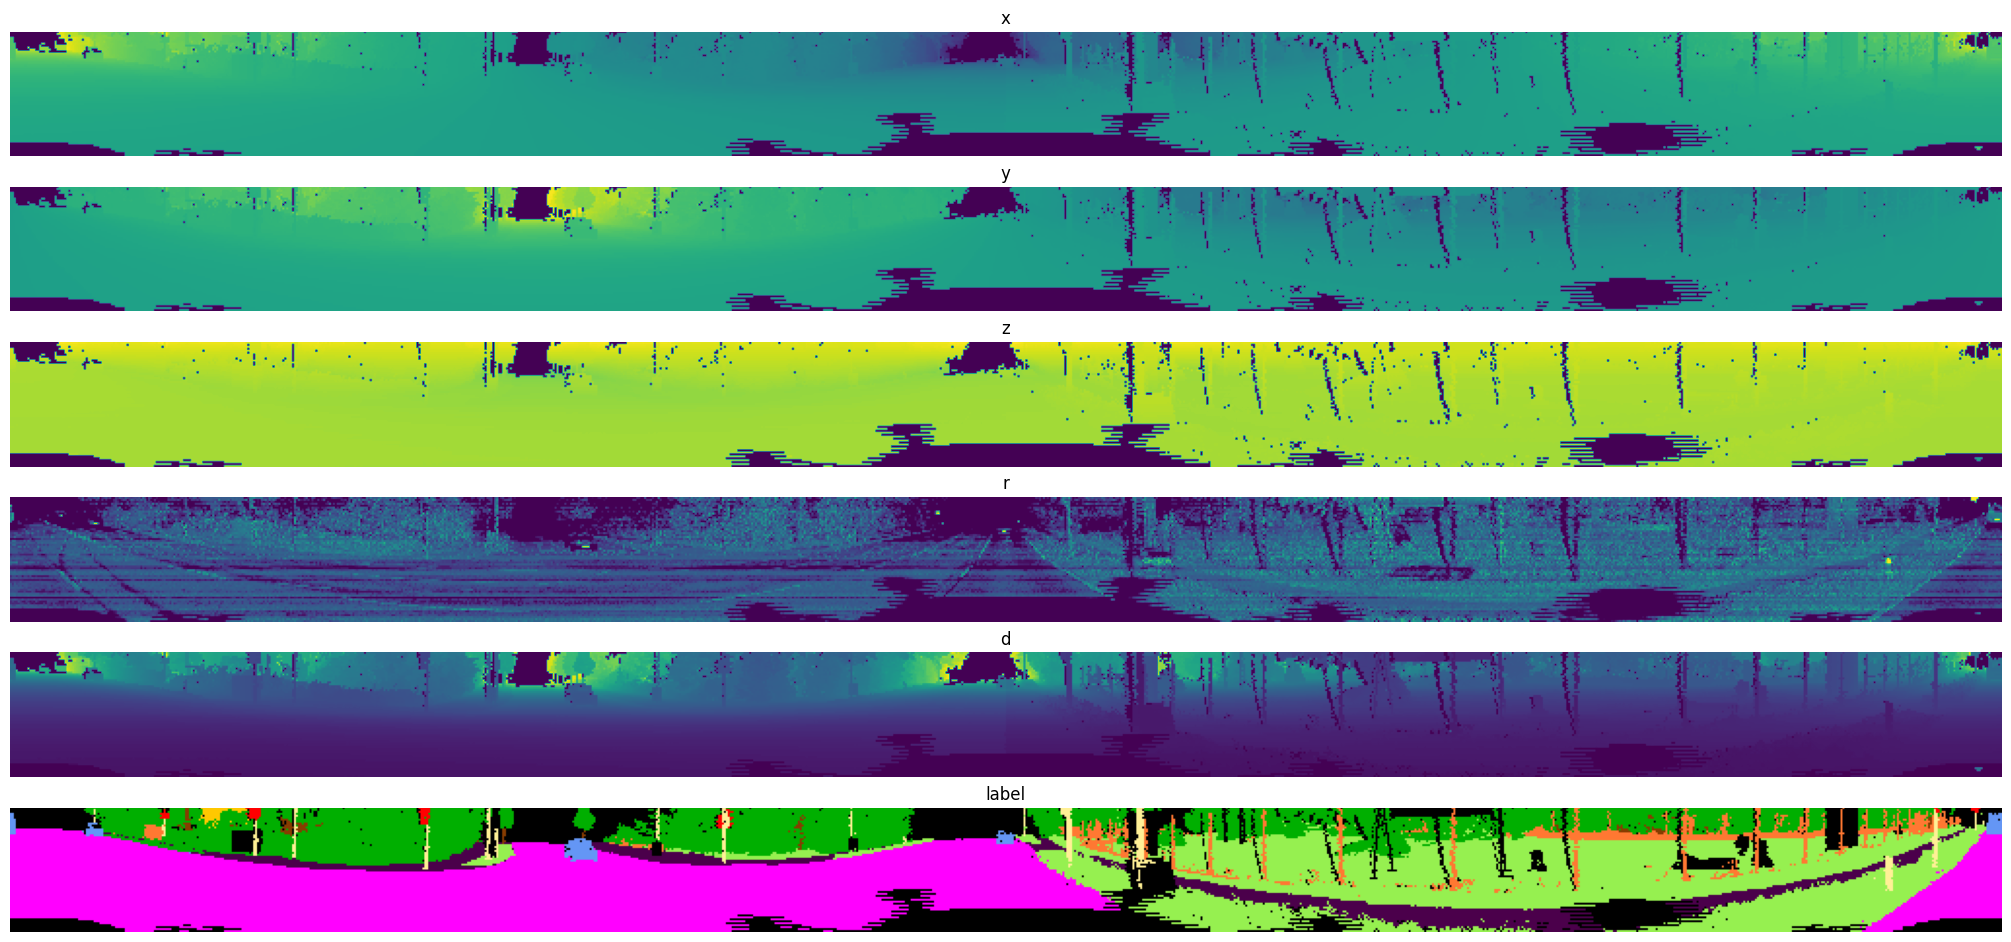

In [ ]:
plot_projections(img, label)

## Class weights

Calculates the frequency of each class in the dataset in order to calculate the weights for the bouding box loss. 

In [ ]:
#| export
def calculate_frequencies(dataset):
    class_frequencies = {i: 0 for i in range(-1, 20)}
    
    for img, labels, _ in dataset:
        # Flatten the label array to count occurrences
        flattened_labels = labels.flatten()
        # Count the occurrences of each class
        unique, counts = np.unique(flattened_labels, return_counts=True)
        # Update the frequency dictionary
        for cls, count in zip(unique, counts):
            class_frequencies[cls] += count

    # change cases where frequency is 0 to 1
    for key, item in class_frequencies.items():
        if item == 0:
            class_frequencies[key] = 1

    class_frequencies = list(class_frequencies.values())
    return class_frequencies

In [ ]:
# Needs the dataset to calculate
# CLASS_FREQUENCIES = calculate_frequencies(ds)

With the class frequencies, calculates the class weights.

In [ ]:
#| export
# Function to calculate class weights
# wc = (ft/fc)^i, where fc is the frequency of class c, and ft is the median of all class frequencies.
def calculate_class_weights(frequencies, exponent):
    median_freq = np.median(frequencies)
    class_weights = (median_freq / frequencies) ** exponent
    return torch.tensor(class_weights, dtype=torch.float32)

In [ ]:
# Class frequencies already calculated for sequence 04 of semantickitti
CLASS_FREQUENCIES = [6413367, 287668, 130217, 1, 1, 1, 19879, 645, 1, 1, 4251576, 9917, 954826, 62496, 168893, 874164, 3405862, 26888, 1075339, 69660, 8859]
EXPONENT_I = 0.5

# Calculate class weights
class_weights = calculate_class_weights(CLASS_FREQUENCIES, EXPONENT_I)
# Weighted cross-entropy loss
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
class_weights

tensor([9.8715e-02, 4.6610e-01, 6.9278e-01, 2.4999e+02, 2.4999e+02, 2.4999e+02,
        1.7731e+00, 9.8434e+00, 2.4999e+02, 2.4999e+02, 1.2124e-01, 2.5104e+00,
        2.5584e-01, 1.0000e+00, 6.0830e-01, 2.6738e-01, 1.3546e-01, 1.5246e+00,
        2.4108e-01, 9.4718e-01, 2.6560e+00])

## TransRVNet Loss

In [ ]:
#| export
class TransRVNet_loss(nn.Module):
    """
    Calculates the total loss with the weighted combination of the three loss functions.
    """
    def __init__(self, device):
        super().__init__()
        # The weight of each loss
        self.Lwce = 1.0
        self.Lls = 3.0
        self.Lbd = 1.0
        self.class_weights = torch.Tensor([4.6610e-01, 6.9278e-01, 2.4999e+02, 2.4999e+02, 2.4999e+02,
        1.7731e+00, 9.8434e+00, 2.4999e+02, 2.4999e+02, 1.2124e-01, 2.5104e+00,
        2.5584e-01, 1.0000e+00, 6.0830e-01, 2.6738e-01, 1.3546e-01, 1.5246e+00,
        2.4108e-01, 9.4718e-01, 2.6560e+00]).to(device)

        self.weighted_cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='none', weight=self.class_weights)
        self.softmax = torch.nn.Softmax(dim=1)
        self.lovasz_softmax_loss = lovasz_softmax
        self.boundary_loss = BoundaryLoss()

    def forward(self, output, target, mask):
        wce_loss = self.weighted_cross_entropy_loss(output, target)
        wce_loss = wce_loss[mask].mean()
        
        output_softmax = self.softmax(output)
        lov_loss = self.lovasz_softmax_loss(output_softmax, target)
        
        bd_loss = self.boundary_loss(output, target, mask)

        # Return the weighted combination of the three loss functions
        return self.Lwce*wce_loss + self.Lls*lov_loss + self.Lbd*bd_loss

In [ ]:
#| hide
ts = torch.randn(1, 20, 64, 1024)
mask = torch.randint(high = 20, size = (1, 64, 1024))

print(ts.shape)
print(mask.shape)

torch.Size([1, 20, 64, 1024])
torch.Size([1, 64, 1024])


In [ ]:
#| hide
loss = TransRVNet_loss('cuda')
l = loss(ts, mask)
l

TypeError: TransRVNet_loss.forward() missing 1 required positional argument: 'mask'

In [ ]:
#|export
def dice_coefficient(pred, target, epsilon=1e-6):
    # Aplica argmax para obter a classe predita em cada pixel
    pred_classes = torch.argmax(pred, dim=1)  # [batch, height, width]
    
    # Converte o target para long para comparação com pred_classes
    target = target.long()
    
    # Calcula o Dice Coefficient para cada classe
    dice_scores = []
    for class_idx in range(pred.shape[1]):
        pred_class = (pred_classes == class_idx).float()  # Pixels que a rede previu como essa classe
        target_class = (target == class_idx).float()  # Pixels que realmente pertencem a essa classe

        # Interseção e união para essa classe
        intersection = torch.sum(pred_class * target_class)
        union = torch.sum(pred_class) + torch.sum(target_class)

        # Calcula o Dice Coefficient
        dice_score = (2 * intersection + epsilon) / (union + epsilon)
        dice_scores.append(dice_score)
    
    # Retorna a média do Dice Coefficient entre todas as classes
    return torch.mean(torch.tensor(dice_scores))


# Transforms

During training, random rotation, random dropping points, and random sign inverting for X and Y values with a probability of 0.5 are applied to augment the input point cloud to avoid overfitting.

In [ ]:
#|export
class RandomRotationTransform(nn.Module):
    """
    Applies a random rotation around the origin to the z
    axis of a given point cloud frame.
    """

    def __init__(self, rotation_axis='xyz'):
        super().__init__()
        self.rotation_axis = rotation_axis

    def get_rotation_matrix(self, axis, angle):
        return np.array([[np.cos(angle), -np.sin(angle), 0],
                             [np.sin(angle), np.cos(angle), 0],
                             [0, 0, 1]])

    def forward(self, frame, label):
        points = frame[:, :3]

        # Apply a random rotation around the z-axis
        angle = np.random.uniform(0, 2 * np.pi)
        rotation_matrix = self.get_rotation_matrix('z', angle)
        points = points @ rotation_matrix.T

        # Combine the rotated x, y, z coordinates with the original depth and reflectance
        rotated_frame = np.hstack((points, frame[:, 3:]))

        return rotated_frame, label

NameError: name 'nn' is not defined

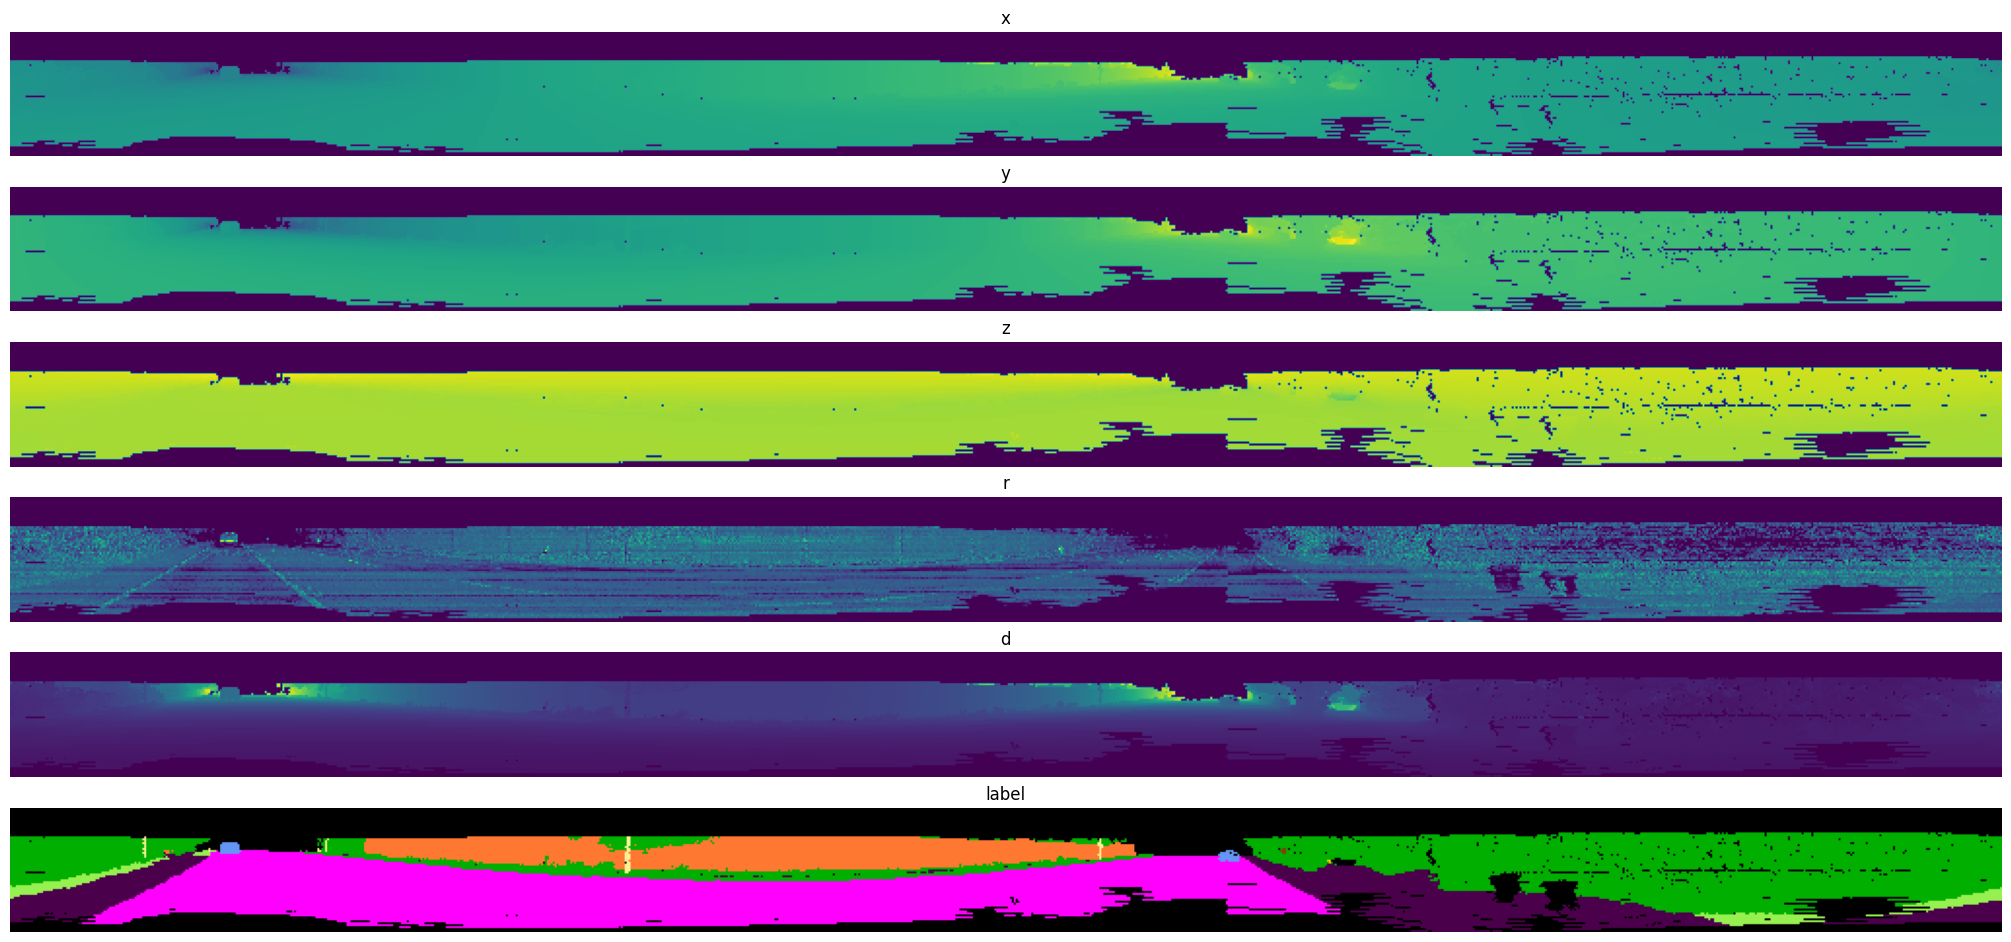

In [ ]:
#| eval: false
data_path = '../../data'
ds = SemanticKITTIDataset(data_path)
proj = SphericalProjection(fov_up_deg=12., fov_down_deg=-26., W=1024, H=64)
tfms = v2.Compose([
    RandomRotationTransform(),
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np)
])
ds.set_transform(tfms)
frame_img, label_img, mask_img = ds[128]
plot_projections(frame_img, label_img)

In [ ]:
#|export
class RandomDroppingPointsTransform(nn.Module):
    """
    Randomly drops a fraction of points from a point cloud frame and its corresponding labels. 
    The fraction of points to drop is controlled by the `drop_fraction` parameter.
    """
    def __init__(self, drop_fraction=0.5):
        super().__init__()
        self.drop_fraction = drop_fraction

    def forward(self, frame, label):
        # Determine the number of points to drop
        num_points_to_drop = int(self.drop_fraction * frame.shape[0])
        
        # Randomly select indices to drop
        drop_indices = np.random.choice(frame.shape[0], num_points_to_drop, replace=False)
        
        # Drop the points and corresponding labels
        points_dropped = np.delete(frame, drop_indices, axis=0)
        labels_dropped = np.delete(label, drop_indices, axis=0)

        return points_dropped, labels_dropped

NameError: name 'nn' is not defined

In [ ]:
#| eval: false
data_path = '../../data'
ds = SemanticKITTIDataset(data_path)
proj = SphericalProjection(fov_up_deg=12., fov_down_deg=-26., W=1024, H=64)
tfms = v2.Compose([
    RandomDroppingPointsTransform(),
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np)
])
ds.set_transform(tfms)
frame_img, label_img, mask_img = ds[128]
plot_projections(frame_img, label_img)

NameError: name 'SemanticKITTIDataset' is not defined

In [ ]:
#|export
class RandomSingInvertingTransform(nn.Module):
    """
    Sign inverting for the X and Y channels.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frame, label):
        frame[:, 0] = -frame[:, 0]
        frame[:, 1] = -frame[:, 1]

        return frame, label

NameError: name 'nn' is not defined

In [ ]:
#| eval: false
data_path = '../../data'
ds = SemanticKITTIDataset(data_path)
proj = SphericalProjection(fov_up_deg=12., fov_down_deg=-26., W=1024, H=64)
tfms = v2.Compose([
    RandomSingInvertingTransform(),
    ProjectionTransform(proj),
    ProjectionVizTransform(ds.color_map_rgb_np, ds.learning_map_inv_np)
])
ds.set_transform(tfms)
frame_img, label_img, mask_img = ds[128]
plot_projections(frame_img, label_img)

NameError: name 'SemanticKITTIDataset' is not defined

# LightningModule for standard experiments

In [ ]:
#| export
def log_activations(logger, step, model, img):
    "Function that uses a Pytorch forward hook to log properties of activations for debugging purposes."
    def debugging_hook(module, inp, out):            
        # if 'relu' in module.name:
        if False:
            acts = out.detach()
            
            min_count = (acts < 1e-1).sum((0, 2, 3))
            shape = acts.shape
            total_count = shape[0]*shape[2]*shape[3]
            rate = min_count/total_count
            logger.log({"max_dead_rate/" + str(module.name): rate.max()}, step=step)
            
            #acts_flat = acts.cpu().view(-1,)
            #acts_hist = np.histogram(acts_flat.log1p(), 100)
            #logger.log({"relu_hist/" + str(module.name): wandb.Histogram(np_histogram=acts_hist)}, step=step)
            
    with register_module_forward_hook(debugging_hook):
        xyz = img[:, :3, :, :]
        reflectance = img[:, 3, :, :].unsqueeze(1)
        depth = img[:, 4, :, :].unsqueeze(1)     
        model(reflectance, depth, xyz)

In [ ]:
#| export
def log_imgs(pred, label, mask, viz_tfm, logger, stage, step):
    "TODO: documentation missing"
    pred_np = pred[0].detach().cpu().numpy().argmax(0)
    label_np = label[0].detach().cpu().numpy()
    mask_np = mask[0].detach().cpu().numpy()
    pred_np[pred_np == label_np] = 0
    _, pred_img, _ = viz_tfm(None, pred_np, mask_np)
    _, label_img, _ = viz_tfm(None, label_np, mask_np)
    img_cmp = np.concatenate((pred_img, label_img), axis=0)
    img_cmp = wandb.Image(img_cmp)
    logger.log({f"{stage}_examples": img_cmp}, step=step)

In [ ]:
#| export
class SemanticSegmentationTask(LightningModule):
    "Lightning Module to standardize experiments with semantic segmentation tasks."
    def __init__(self, model, loss_fn, viz_tfm, total_steps, lr=1e-1):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.viz_tfm = viz_tfm
        self.lr = lr
        self.total_steps = total_steps
        self.dropout = torch.nn.Dropout(p=0.2, inplace=False)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=model.n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=model.n_classes)
        self.automatic_optimization = False

        self.step_idx = 0
        
        for n, m in self.model.named_modules():
            assert not hasattr(m, 'name')
            m.name = n
        
    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.lr, weight_decay=0.0001)
        lr_scheduler = OneCycleLR(optimizer, max_lr=0.002, div_factor=1, final_div_factor=10, steps_per_epoch=self.total_steps, epochs=30)
        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}
    
    def training_step(self, batch, batch_idx):
        stage = 'train'
        logger = self.logger.experiment

        loss, pred, label, mask = self.step(batch, batch_idx, stage, self.train_accuracy)
        # if int(0.01*self.total_steps) != 0:
        #     if self.step_idx % int(0.01*self.total_steps) == 0:
        #         log_activations(logger, self.step_idx, self.model, batch[0])
        #     if self.step_idx % int(0.25*self.total_steps) == 0:
        #         log_imgs(pred, label, mask, self.viz_tfm, logger, stage, self.step_idx)
        self.manual_optimization(loss)
        self.step_idx += 1
    
    def on_train_epoch_end(self):
        self.log('train_acc_epoch', self.train_accuracy)

    def validation_step(self, batch, batch_idx):
        stage = 'val'
        logger = self.logger.experiment
        
        _, pred, label, mask = self.step(batch, batch_idx, stage, self.val_accuracy)
        # if batch_idx == 0:
        #     log_imgs(pred, label, mask, self.viz_tfm, logger, stage, self.step_idx)
    
    def step(self, batch, batch_idx, stage, metric):
        img, label, mask = batch

        # Separate channels
        xyz = img[:, :3, :, :]
        reflectance = img[:, 3, :, :].unsqueeze(1)
        depth = img[:, 4, :, :].unsqueeze(1)        
        
        pred = self.model(reflectance, depth, xyz)
        
        # Apply dropout
        pred = self.dropout(pred)
        
        label[~mask] = 0
        loss = self.loss_fn(pred, label, mask)
        print('dice: ', dice_coefficient(pred, label))


        pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
        pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
        mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
        pred_m = pred_f[mask_f, :]
        label_m = label[mask]
        metric(pred_m, label_m)
        
        self.log(f"{stage}_acc_step", metric)
        self.log(f"{stage}_loss_step", loss.log10())

        return loss, pred, label, mask
    
    def manual_optimization(self, loss):
        optimizer = self.optimizers()
        optimizer.zero_grad()
        self.manual_backward(loss)
        
        p_old = {}
        for n, p in self.model.named_parameters():
            p_old[n] = p.detach().clone()
        
        optimizer.step()
        
        for n, p in self.model.named_parameters():
            optim_step = p.detach() - p_old[n]
            
            #log_rate = optim_step.abs().log1p() - p_old[n].abs().log1p()
            #log_rate_hist = np.histogram(log_rate.cpu().view(-1), 100)
            #self.logger.experiment.log({"log_update_rate_hist/" + str(n): wandb.Histogram(np_histogram=log_rate_hist)}, step=self.step_idx)
            
            self.logger.experiment.log({"ud/" + str(n): ((optim_step.std())/(p_old[n].std() + 1e-5)).log10()}, step=self.step_idx)
        
        lr_scheduler = self.lr_schedulers()
        lr_scheduler.step()

NameError: name 'LightningModule' is not defined

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()